In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [5]:
# Load the data
df = pd.read_csv('bank-additional/bank-additional.csv', sep=';')

In [16]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values
# For numerical columns, use median imputation
num_columns = df.select_dtypes(include=['int64', 'float64']).columns
num_imputer = SimpleImputer(strategy='median')
df[num_columns] = num_imputer.fit_transform(df[num_columns])

# For categorical columns, use mode imputation
cat_columns = df.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_columns] = cat_imputer.fit_transform(df[cat_columns])


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


ValueError: at least one array or dtype is required

In [6]:
print("\nData Info:")
print(df.info())

print("\nDescriptive Statistics:")
print(df.describe())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 

In [ ]:
# Encode categorical variables
label_encoder = LabelEncoder()
for col in cat_columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Scale numerical features
scaler = StandardScaler()
X = df.drop('y', axis=1)
y = df['y']

X_scaled = scaler.fit_transform(X)

In [17]:
# Use SelectKBest to choose top features
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature indices
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]


Tuning Logistic Regression...
Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best Score for Logistic Regression: 0.9165
Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Best Score for Random Forest: 0.9138
Tuning Neural Network...
Best Parameters for Neural Network: {'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': (50, 50), 'max_iter': 1000}
Best Score for Neural Network: 0.9190


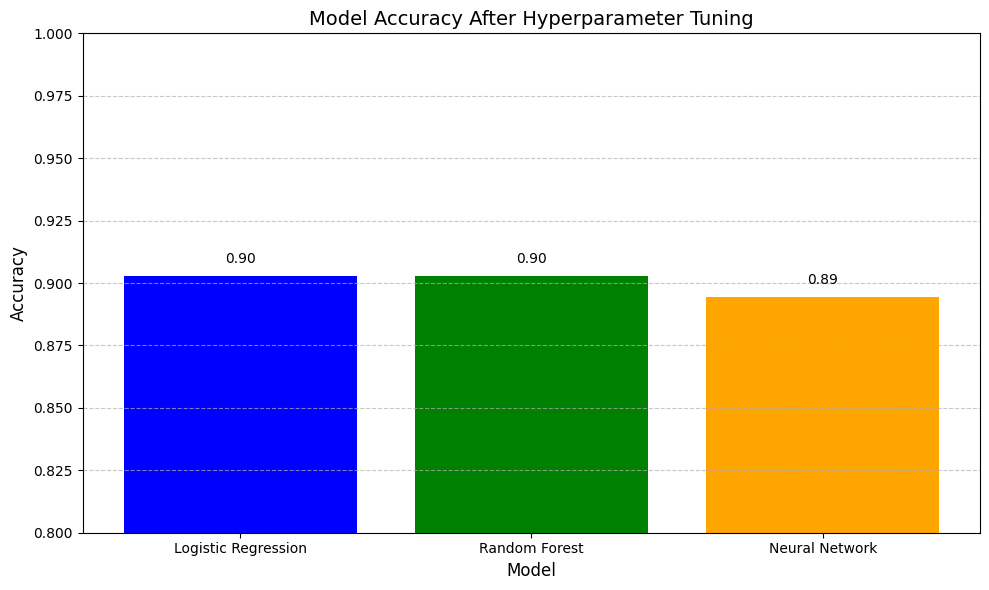

In [25]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

# Define hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['tanh', 'relu'],
        'max_iter': [500, 1000],
        'early_stopping': [True]
    }
}

# Store results
tuned_results = {}
# Perform hyperparameter tuning for each model
for name, model in models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='accuracy',
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    tuned_results[name] = grid_search.best_params_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")
    print(f"Best Score for {name}: {grid_search.best_score_:.4f}")

# Collect accuracy scores for tuned models
scores = []
for name, params in tuned_results.items():
    model = models[name].set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append((name, accuracy))

# Plot accuracy scores with Matplotlib
models_names, accuracies = zip(*scores)

plt.figure(figsize=(10, 6))
plt.bar(models_names, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy After Hyperparameter Tuning', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.8, 1.0)  # Adjust y-axis to focus on higher accuracy
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotate bars with accuracy values
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.005, f"{accuracy:.2f}", ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report
for name, params in tuned_results.items():
    model = models[name].set_params(**params)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       732
           1       0.61      0.36      0.45        92

    accuracy                           0.90       824
   macro avg       0.77      0.67      0.70       824
weighted avg       0.89      0.90      0.89       824

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       732
           1       0.59      0.46      0.52        92

    accuracy                           0.90       824
   macro avg       0.76      0.71      0.73       824
weighted avg       0.90      0.90      0.90       824

Classification Report for Neural Network:

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       732
           1       0.58      0.39      0.47        92

    accuracy                           0.90      

In [22]:
feature_scores = selector.scores_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': feature_scores
}).sort_values(by='Score', ascending=False)
print(feature_importance_df.head(10))


           Feature       Score
10        duration  874.494742
19     nr.employed  571.902853
12           pdays  510.047074
18       euribor3m  402.909438
15    emp.var.rate  359.027148
13        previous  288.002435
7          contact   79.220260
14        poutcome   63.655628
16  cons.price.idx   40.191766
4          default   24.316695


In [23]:
from joblib import dump
for name, params in tuned_results.items():
    model = models[name].set_params(**params)
    model.fit(X_train, y_train)
    dump(model, f"{name.replace(' ', '_')}_best_model.pkl")
